**Deep Learning - Project**      

**Part 2**                             

Name: Christodoulidis Anastasios         
Α.Μ.: aivc22019

In [44]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical

from keras.models import load_model

In [45]:
# import mnist dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [46]:
# check shapes of sets
print('Training data shape:', x_train.shape)
print('Test data shape:', x_test.shape)

Training data shape: (60000, 28, 28)
Test data shape: (10000, 28, 28)


In [47]:
# Get classes
classes = np.unique(y_train)

# Print the classes
print('Classes:', classes)

Classes: [0 1 2 3 4 5 6 7 8 9]


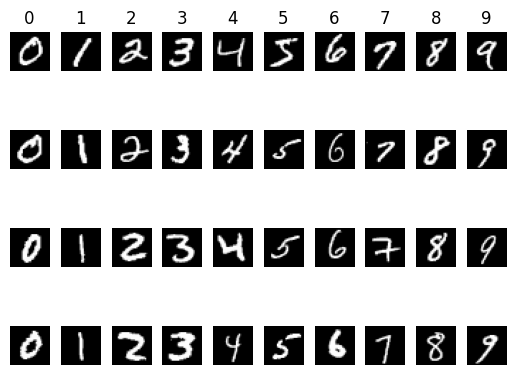

In [48]:
# Plot some of the data
for class_label in classes:
    # Find the indices of the current class in the training labels
    indices = np.where(y_train == class_label)[0][:4]

    # Plot the images
    for i, index in enumerate(indices):
        plt.subplot(4, len(classes), i * len(classes) + class_label + 1)
        plt.imshow(x_train[index], cmap='gray')
        plt.axis('off')

        # Add class label as the title
        if i == 0:
            plt.title(str(class_label))

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Display the plot
plt.show()


In [49]:
# Counts of each class in train and test set

# Count the occurrences of each class in the training set
train_counts = np.bincount(y_train)

# Count the occurrences of each class in the test set
test_counts = np.bincount(y_test)

# Create a dataframe for the training set counts
train_counts = pd.DataFrame({'Class': classes, 'Count': train_counts})

# Create a dataframe for the test set counts
test_counts = pd.DataFrame({'Class': classes, 'Count': test_counts})

# Set the 'Class' column as the index
train_counts.set_index('Class', inplace=True)
test_counts.set_index('Class', inplace=True)

# Print the dataframe for the training set counts
print("Training set:")
print(train_counts)

# Print the dataframe for the test set counts
print("\nTest set:")
print(test_counts)

Training set:
       Count
Class       
0       5923
1       6742
2       5958
3       6131
4       5842
5       5421
6       5918
7       6265
8       5851
9       5949

Test set:
       Count
Class       
0        980
1       1135
2       1032
3       1010
4        982
5        892
6        958
7       1028
8        974
9       1009


In [50]:
# Split training set into 6 sets using kFold while keeping 10000 entries as a validation set

# Create K-Fold cross-validator
kfold = KFold(n_splits=6, shuffle=True)

# Initialize a dictionary to store the splits
splits = {}
input_size = x_train.shape[1]*x_train.shape[1]  # input size

# Split the data into folds and store in the dictionary
for fold, (train_index, val_index) in enumerate(kfold.split(x_train)):
  x_train_fold = x_train[train_index]
  x_train_fold = np.reshape(x_train_fold, [-1, input_size])
  x_train_fold = x_train_fold.astype('float32') / 255

  y_train_fold = y_train[train_index]

  x_val = x_train[val_index]
  x_val = np.reshape(x_val, [-1, input_size])
  x_val = x_val.astype('float32') / 255

  y_val = y_train[val_index]

  split_name = f"split_{fold+1}"
  splits[split_name] = {
      'x_train': x_train_fold,
      'x_val': x_val,
      'y_train': y_train_fold,
      'y_val': y_val
  }

# Size of splits
for split_name, split_data in splits.items():
  print(f"{split_name}:")
  print("Training set size:", len(split_data['x_train']))
  print("Validation set size:", len(split_data['x_val']))
  print()


split_1:
Training set size: 50000
Validation set size: 10000

split_2:
Training set size: 50000
Validation set size: 10000

split_3:
Training set size: 50000
Validation set size: 10000

split_4:
Training set size: 50000
Validation set size: 10000

split_5:
Training set size: 50000
Validation set size: 10000

split_6:
Training set size: 50000
Validation set size: 10000



In [51]:
# Reshape x_test
x_test = np.reshape(x_test, [-1, input_size])
x_test = x_test.astype('float32') / 255

In [52]:
# Create Results dataframe
results = pd.DataFrame(columns=['Technique Name', 'Set', 'Fold number', 'Accuracy',
                           'Precision', 'Recall', 'F1 Score'])

# DNN

In [53]:
# Build and compile the DNN model

model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_dim=input_size),
    tf.keras.layers.Dropout(0.45),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.45),
    tf.keras.layers.Dense(len(classes), activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 256)               200960    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 10)                2570      
                                                                 
Total params: 269,322
Trainable params: 269,322
Non-trainable params: 0
_________________________________________________________________


In [54]:
def fit_model(x_train, y_train, x_val, y_val, epochs):

  """
  Fit model based on 'x_train' and 'y_train',
  use 'x_val' and 'y_val' as valuation data,
  for a given number of epochs.

  Print the loss of the Training and Validation set
  """

  # One-hot encode the labels
  y_train = to_categorical(y_train)
  y_val = to_categorical(y_val)

  # Fit the model with validation data
  history=model.fit(
      x_train, y_train,
      epochs=epochs,
      verbose=1,
      validation_data=(x_val, y_val)
  )

  # Print the training and validation losses
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']
  print(f"Training Loss = {round(train_loss[epochs-1],4)}, Validation Loss = {round(val_loss[epochs-1],4)}")

  # for epoch in range(epochs):
  #     print(f"Epoch {epoch+1}: Training Loss = {train_loss[epoch]}, Validation Loss = {val_loss[epoch]}")


  return model


In [55]:
def predictNresults(tech_name, x_train, y_train, mdl, fold):

  """
  Predict the output of the 'x_train' and 'x_test'(global variable).
  Calculate accuracy, precision, recall and f1-score according to 'y_train'
  and 'y_test'(global variable) respectivly.
  Save results to 'results' dataframe.

  Variables:
  tech_name='DNN' or 'CNN'
  x_train = Training input data
  y_train = Training real output data
  mdl = fitted model
  fold = fold number of KFold
  """

  # Make predictions for the training set
  train_pred_labels = np.argmax(mdl.predict(x_train), axis=1)

  # Make predictions for the test set
  test_pred_labels = np.argmax(mdl.predict(x_test), axis=1)

  # Calculate metrics for the training set
  train_accuracy = round(accuracy_score(y_train, train_pred_labels),4)
  train_precision = round(precision_score(y_train, train_pred_labels, average='macro'),4)
  train_recall = round(recall_score(y_train, train_pred_labels, average='macro'),4)
  train_f1 = round(f1_score(y_train, train_pred_labels, average='macro'),4)

  # Add results to 'results' dataframe
  result=[tech_name, 'Train', fold, train_accuracy, train_precision,
          train_recall, train_f1]
  results.loc[len(results)] = result

  # Calculate metrics for the test set
  test_accuracy = round(accuracy_score(y_test, test_pred_labels),4)
  test_precision = round(precision_score(y_test, test_pred_labels, average='macro'),4)
  test_recall = round(recall_score(y_test, test_pred_labels, average='macro'),4)
  test_f1 = round(f1_score(y_test, test_pred_labels, average='macro'),4)

  # Add results to 'results' dataframe
  result=[tech_name, 'Test', fold, test_accuracy, test_precision,
          test_recall, test_f1]
  results.loc[len(results)] = result


In [56]:
# Fit DNN models
# Store models into 'dnn' list
# Predict and Calculate Results

# Start the timer
start_time = time.time()

dnn=[]
for i in range(1,7):
  split=f'split_{i}'
  print(f'DNN-fold {i}')
  dnn.append(fit_model(splits[split]['x_train'], splits[split]['y_train'],splits[split]['x_val'],splits[split]['y_val'],10))
  print()
  print(f'DNN-Model {i} Prediction')
  predictNresults('DNN', splits[split]['x_train'], splits[split]['y_train'], dnn[i-1], i)
  print()
  print()

# End the timer
end_time = time.time()

DNN-fold 1
Epoch 1/10
1563/1563 [==============================] - 7s 4ms/step - loss: 0.3704 - accuracy: 0.8876 - val_loss: 0.1372 - val_accuracy: 0.9581
Epoch 2/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1978 - accuracy: 0.9410 - val_loss: 0.1077 - val_accuracy: 0.9686
Epoch 3/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.1597 - accuracy: 0.9520 - val_loss: 0.0921 - val_accuracy: 0.9723
Epoch 4/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.1422 - accuracy: 0.9575 - val_loss: 0.0825 - val_accuracy: 0.9751
Epoch 5/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.1270 - accuracy: 0.9613 - val_loss: 0.0839 - val_accuracy: 0.9743
Epoch 6/10
1563/1563 [==============================] - 7s 4ms/step - loss: 0.1157 - accuracy: 0.9646 - val_loss: 0.0714 - val_accuracy: 0.9795
Epoch 7/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.1083 - accuracy: 0.9678 - val_loss: 0.0794 - v

In [57]:
# Calculate the execution time in seconds
execution_time_DNN = end_time - start_time

# Print the execution time
print("Execution time-DNN:", execution_time_DNN/60, "minutes")

Execution time-DNN: 8.245260882377625 minutes


In [58]:
# Save best DNN model to a .h5 file
best_dnn_no = int(results.loc[(results['Technique Name'] == 'DNN') & (results['Set'] == 'Test' ), 'Accuracy'].idxmax())
best_dnn_no = results.at[best_dnn_no, 'Fold number']
dnn[best_dnn_no-1].save('/content/drive/MyDrive/Deep Learning/DNN.h5')

313/313 [==============================] - 1s 2ms/step


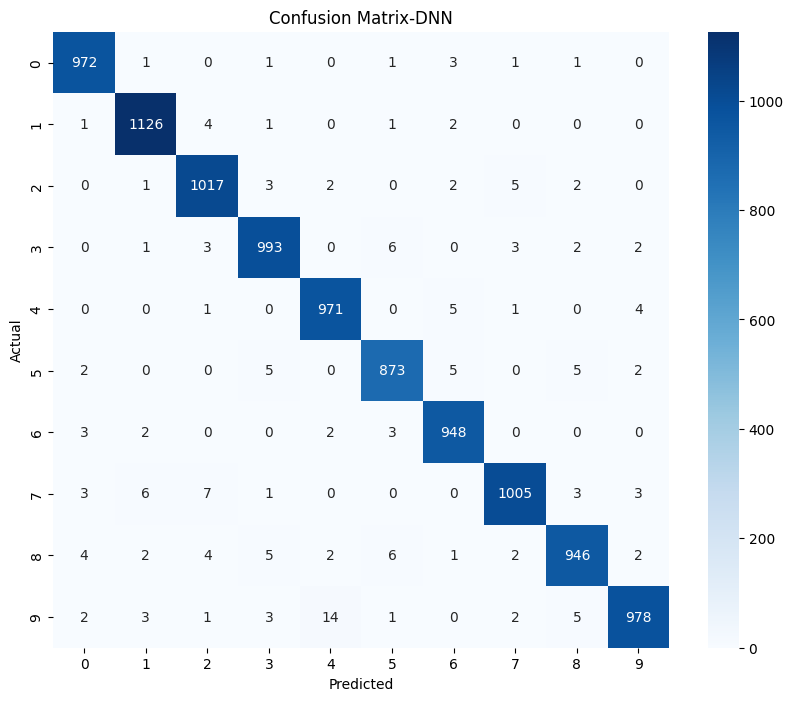

In [59]:
# Make predictions for the test set
pred = np.argmax(dnn[best_dnn_no-1].predict(x_test), axis=1)

# Create the confusion matrix
cm = confusion_matrix(y_test, pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True,
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix-DNN')
plt.show()

### CNN

In [60]:
# Build and compile the CNN model

input_shape = (28, 28, 1)
# Define the model architecture
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Dropout(0.25))  # Add dropout layer
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Add dropout layer
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 dropout_4 (Dropout)         (None, 26, 26, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)             

In [61]:
# Fit CNN models and Calculate Results
# Store models into 'cnn' list

# Start the timer
start_time = time.time()

x_test = x_test.reshape(x_test.shape[0], *[28,28,1])
cnn=[]
for i in range(1,7):
  split=f'split_{i}'
  print(f'CNN-fold {i}')
  train = splits[split]['x_train'].reshape(splits[split]['x_train'].shape[0],*[28,28,1])
  val = splits[split]['x_val'].reshape(splits[split]['x_val'].shape[0],*[28,28,1])
  cnn.append(fit_model(train, splits[split]['y_train'],val,splits[split]['y_val'],10))
  print()
  print(f'CNN-Model {i} Prediction')
  predictNresults('CNN', train, splits[split]['y_train'], cnn[i-1], i)
  print()
  print()

# End the timer
end_time = time.time()

CNN-fold 1
Epoch 1/10
1563/1563 [==============================] - 12s 5ms/step - loss: 0.2469 - accuracy: 0.9248 - val_loss: 0.0646 - val_accuracy: 0.9809
Epoch 2/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.0974 - accuracy: 0.9713 - val_loss: 0.0476 - val_accuracy: 0.9853
Epoch 3/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.0677 - accuracy: 0.9799 - val_loss: 0.0341 - val_accuracy: 0.9896
Epoch 4/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.0571 - accuracy: 0.9834 - val_loss: 0.0368 - val_accuracy: 0.9892
Epoch 5/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.0469 - accuracy: 0.9857 - val_loss: 0.0336 - val_accuracy: 0.9897
Epoch 6/10
1563/1563 [==============================] - 7s 5ms/step - loss: 0.0408 - accuracy: 0.9875 - val_loss: 0.0263 - val_accuracy: 0.9917
Epoch 7/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0360 - accuracy: 0.9893 - val_loss: 0.0277

In [62]:
# Calculate the execution time in seconds
execution_time_CNN = end_time - start_time

# Print the execution time
print("Execution time-CNN:", execution_time_CNN/60, "minutes")

Execution time-CNN: 9.709102074305216 minutes


In [63]:
results

,Technique Name,Set,Fold number,Accuracy,Precision,Recall,F1 Score
0,DNN,Train,1,0.9910,0.9910,0.9910,0.9910
1,DNN,Test,1,0.9785,0.9783,0.9784,0.9783
2,DNN,Train,2,0.9952,0.9951,0.9952,0.9952
3,DNN,Test,2,0.9798,0.9797,0.9797,0.9797
4,DNN,Train,3,0.9971,0.9971,0.9970,0.9970
5,DNN,Test,3,0.9804,0.9804,0.9802,0.9803
6,DNN,Train,4,0.9973,0.9973,0.9974,0.9973
7,DNN,Test,4,0.9813,0.9812,0.9812,0.9812
8,DNN,Train,5,0.9975,0.9974,0.9975,0.9974
9,DNN,Test,5,0.9812,0.9811,0.9811,0.9811


In [64]:
# Save 'results' dataframe to csv file
results.to_csv('/content/drive/MyDrive/Deep Learning/erotima1.csv', index=False)

In [65]:
# Save best CNN model to a .h5 file
best_cnn_no = int(results.loc[(results['Technique Name'] == 'CNN') & (results['Set'] == 'Test' ), 'Accuracy'].idxmax())
best_cnn_no = results.at[best_cnn_no, 'Fold number']
cnn[best_cnn_no-1].save('/content/drive/MyDrive/Deep Learning/CNN.h5')

313/313 [==============================] - 1s 2ms/step


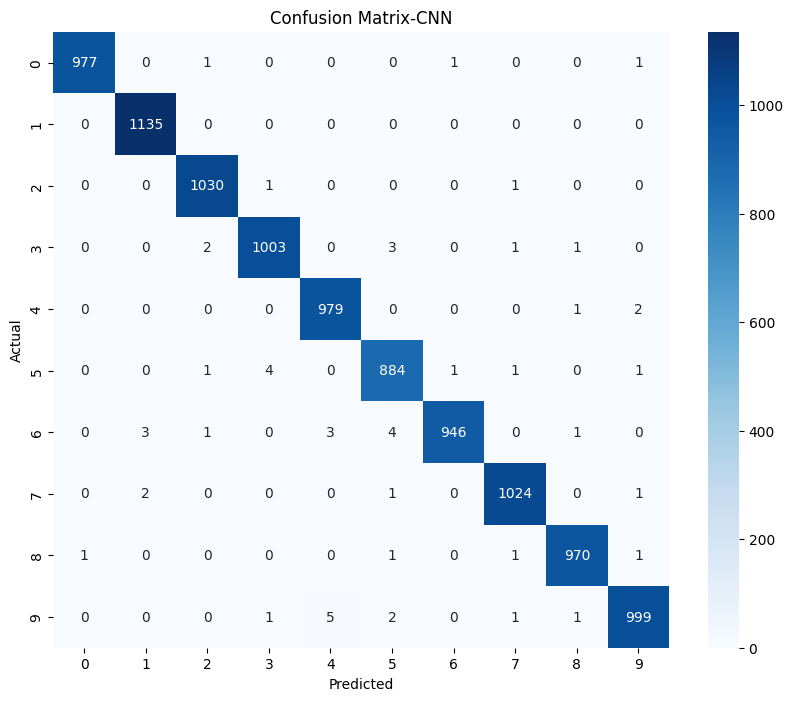

In [66]:
# Make predictions for the test set
pred = np.argmax(cnn[best_cnn_no-1].predict(x_test), axis=1)

# Create the confusion matrix
cm = confusion_matrix(y_test, pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True,
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix-CNN')
plt.show()

### Visualise Feature Maps

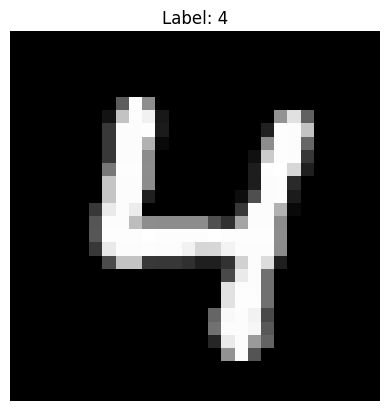

In [14]:
# # Load the MNIST dataset
# mnist = tf.keras.datasets.mnist
# (_, _), (images, labels) = mnist.load_data()

# # Select an image from the dataset
# image_index = 56  # Change this index to select a different image
# selected_image = images[image_index]
# selected_label = labels[image_index]

# # Display the selected image
# plt.imshow(selected_image, cmap='gray')
# plt.title(f"Label: {selected_label}")
# plt.axis('off')
# plt.show()

1/1 [==============================] - 0s 55ms/step


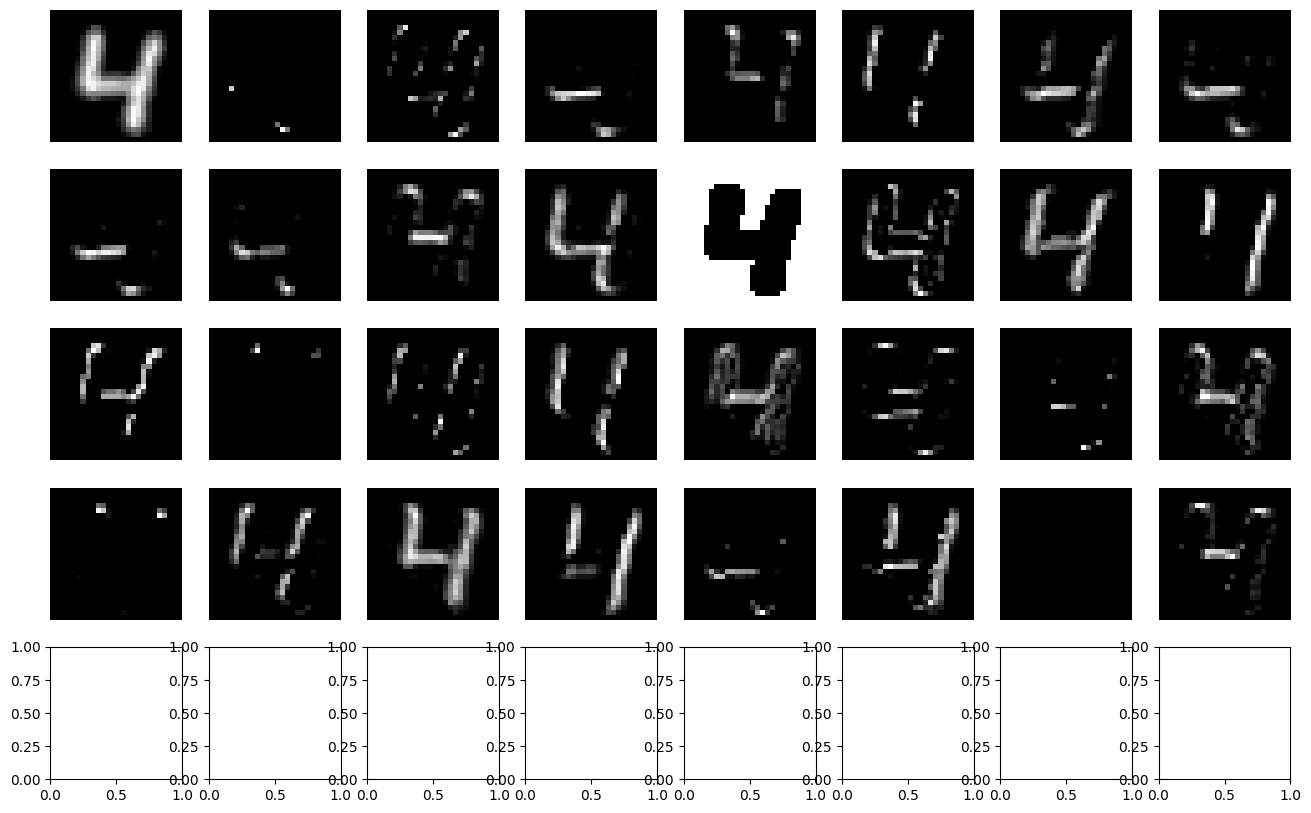

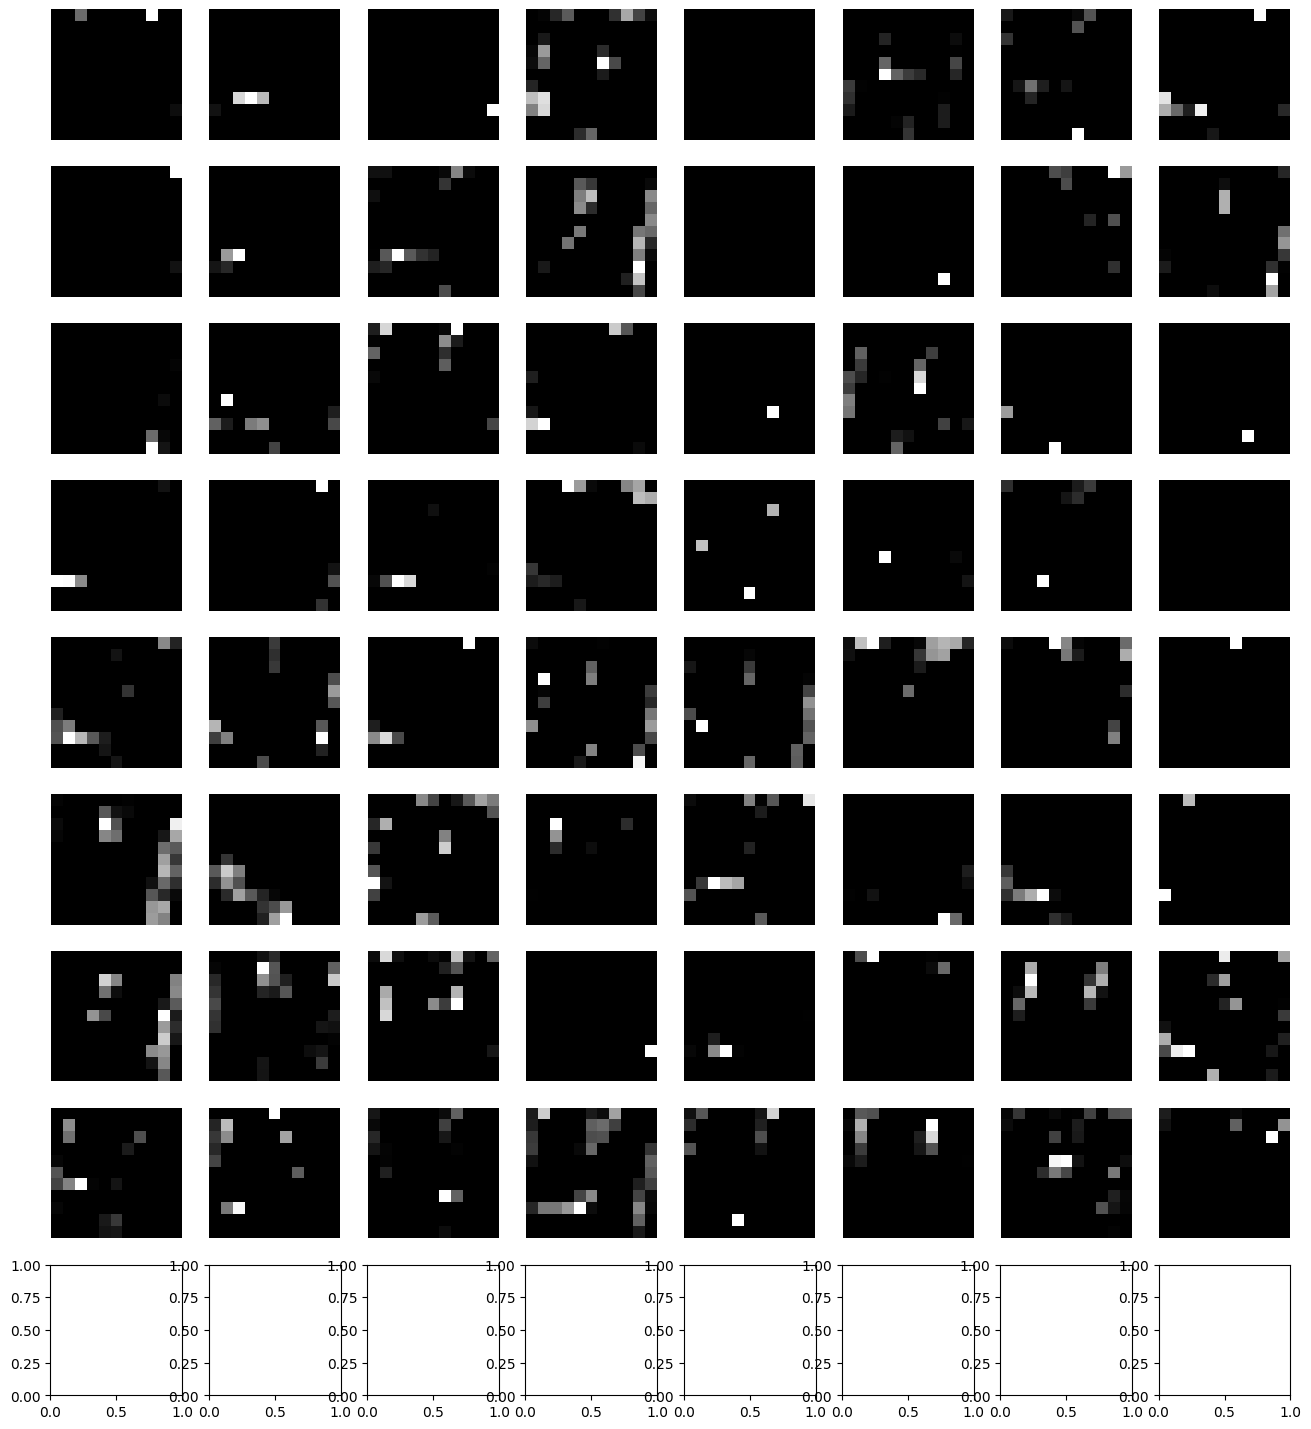

In [15]:
# from google.colab import drive
# # Mount Google Drive
# drive.mount('/content/drive')
# # Load your pre-trained model or define a new one
# model_CNN = tf.keras.models.load_model('/content/drive/MyDrive/Deep Learning/CNN.h5')

# # Get the desired layer(s) by name or index
# layer_names = ['conv2d', 'conv2d_1']
# layers = [model.get_layer(name) for name in layer_names]

# # Create a new model that outputs the desired layer(s) activations
# activation_model = tf.keras.models.Model(inputs=model.inputs, outputs=[layer.output for layer in layers])

# # Load or preprocess an input image
# image_array = tf.keras.preprocessing.image.img_to_array(selected_image)
# image_array = np.expand_dims(image_array, axis=0)

# activations = activation_model.predict(image_array)
# for layer_activation in activations:
#     num_features = layer_activation.shape[-1]  # Number of feature maps in the layer
#     size = layer_activation.shape[1]  # Size of each feature map

#     # Create a grid of subplots to display the feature maps
#     rows = num_features // 8 + 1  # Adjust the number of rows as per your preference
#     fig, ax = plt.subplots(rows, 8, figsize=(16, rows * 2))

#     for i in range(num_features):
#         # Get the i-th feature map
#         feature_map = layer_activation[0, :, :, i]

#         # Plot the feature map
#         row = i // 8
#         col = i % 8
#         ax[row, col].imshow(feature_map, cmap='gray')
#         ax[row, col].axis('off')

#     plt.show()
